In [5]:
from functools import partial
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [2]:
images_dir = '/Users/harshikahooda/Desktop/ML_Project/bacteria/images'
masks_dir = '/Users/harshikahooda/Desktop/ML_Project/bacteria/masks'

dirname, _, filenames = next(os.walk(images_dir))

In [3]:
def load_img_with_mask(image_path, images_dir: str = 'images', masks_dir: str = 'masks',images_extension: str = 'png', masks_extension: str = 'png') -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=1, expand_animations = False)
    return (image, mask)

2022-06-03 12:58:26.096904: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


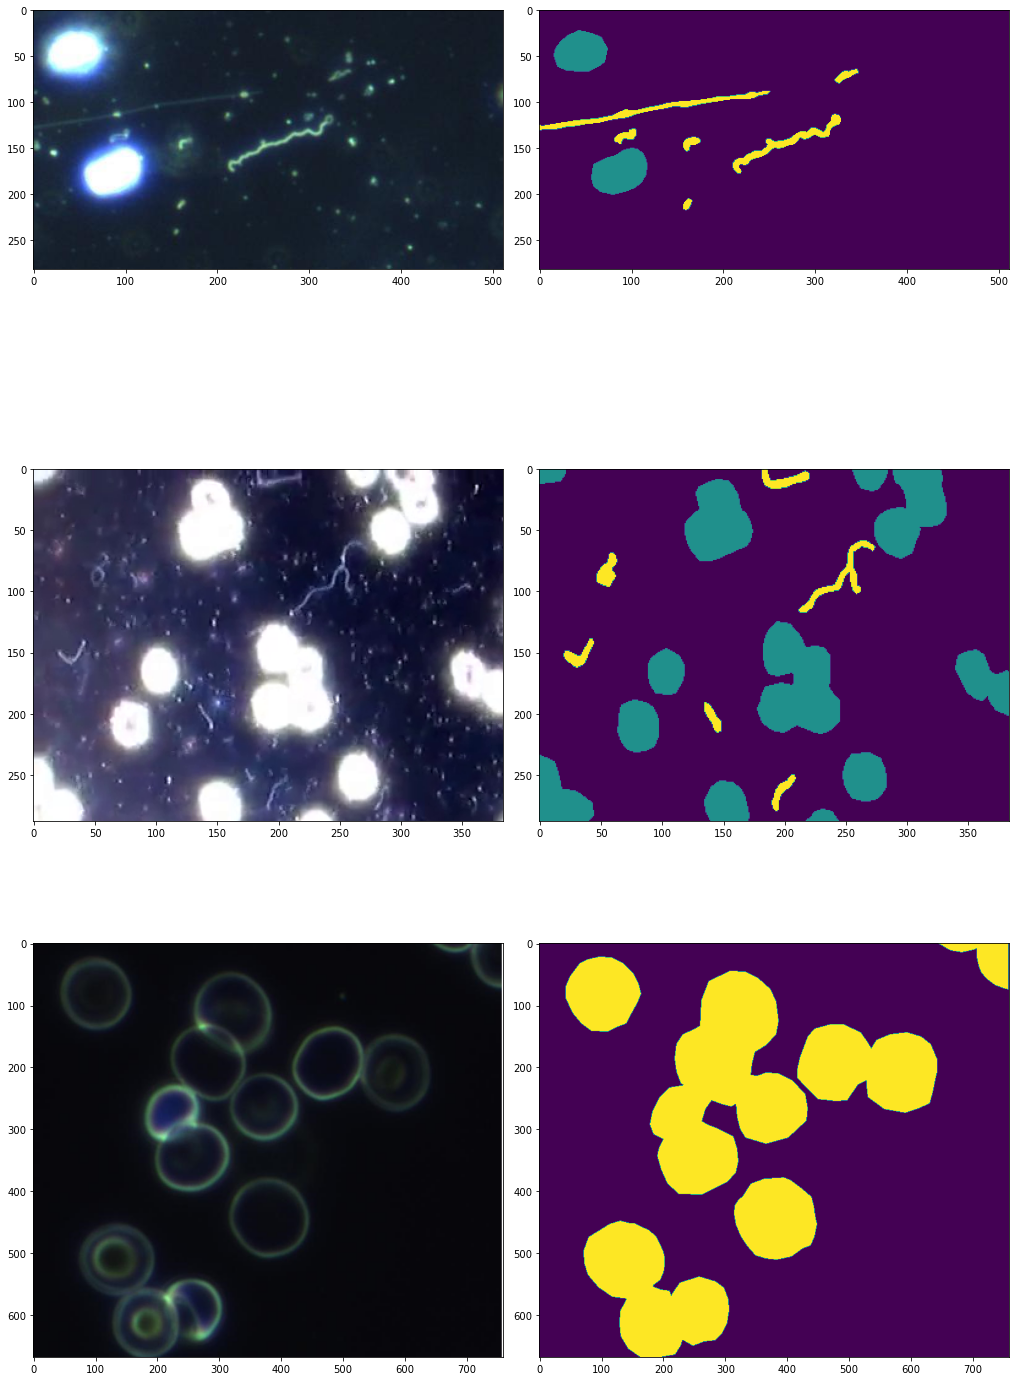

In [4]:
%matplotlib inline
n_examples = 3
examples = [load_img_with_mask(os.path.join(images_dir, filenames[i])) for i in range(n_examples)]

fig, axs = plt.subplots(n_examples, 2, figsize=(14, n_examples*7), constrained_layout=True)
for ax, (image, mask) in zip(axs, examples):
    ax[0].imshow(image)
    ax[1].imshow(mask)

In [6]:
import typing
import numpy as np
import cv2
import os
import tensorflow as tf
from tqdm import tqdm
import gc

class SlidingWindow:
    
    # we are defining the height width and stride with self variable
    def __init__(self, width=256, height=256, stride=256):
        self.width = width
        self.height = height
        self.stride = stride

    def do(self, image, mask) -> typing.List[typing.Tuple[np.ndarray, np.ndarray]]:
        
        # assert will raise an Assertation Error when the output is not as desired
        assert image.shape[0] == mask.shape[0] and image.shape[1] == mask.shape[1]
        
        # defining the condtions for the masks and images to be pre-processed
        
        if image.shape[1] < self.width and image.shape[0] < self.height:
            image = cv2.resize(image, (self.width, self.height), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, (self.width, self.height), interpolation=cv2.INTER_AREA)
            assert image.shape[0] == mask.shape[0] and image.shape[1] == mask.shape[1]
        elif image.shape[1] > self.width and image.shape[0] < self.height:
            w = int(round(self.height * image.shape[1] / image.shape[0]))
            image = cv2.resize(image, (w, self.height), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, (w, self.height), interpolation=cv2.INTER_AREA)
            assert image.shape[0] == mask.shape[0] and image.shape[1] == mask.shape[1]
        elif image.shape[1] < self.width and image.shape[0] > self.height:
            h = int(round(self.width * image.shape[0] / image.shape[1]))
            image = cv2.resize(image, (self.width, h), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, (self.width, h), interpolation=cv2.INTER_AREA)
            assert image.shape[0] == mask.shape[0] and image.shape[1] == mask.shape[1]

        if image.shape[1] == self.width and image.shape[0] == self.height:
            return [(image, mask)]

        ret = []
        # boolean regarding whether or not there was a return at all. 
        # If there is no frame, you wont get an error, you will get None. 
        i_h, i_w, _ = image.shape
        s_h, s_w = self.width, self.height

        if image.shape[1] < self.width + self.stride or image.shape[0] < self.height + self.stride:  
            # Image too small
            left_top = (image[0:s_h, 0:s_w, :], mask[0:s_h, 0:s_w])
            right_bottom = (image[i_h - s_h:i_h, i_w - s_w:i_w, :], mask[i_h - s_h:i_h, i_w - s_w:i_w])
            left_bottom = (image[0:s_h, i_w - s_w: i_w, :], mask[0:s_h, i_w - s_w:i_w])
            right_top = (image[i_h - s_h:i_h, 0:s_w, :], mask[i_h - s_h:i_h, 0:s_w])

            assert left_top[0].shape[0] == self.height and left_top[0].shape[1] == self.width
            assert left_top[1].shape[0] == self.height and left_top[1].shape[1] == self.width
            assert right_bottom[0].shape[0] == self.height and right_bottom[0].shape[1] == self.width
            assert right_bottom[1].shape[0] == self.height and right_bottom[1].shape[1] == self.width
            assert left_bottom[0].shape[0] == self.height and left_bottom[0].shape[1] == self.width
            assert left_bottom[1].shape[0] == self.height and left_bottom[1].shape[1] == self.width
            assert right_top[0].shape[0] == self.height and right_top[0].shape[1] == self.width
            assert right_top[1].shape[0] == self.height and right_top[1].shape[1] == self.width

            ret.append(left_top)
            ret.append(right_bottom)
            ret.append(left_bottom)
            ret.append(right_top)
            
        elif image.shape[1] < self.width + self.stride and image.shape[0] > self.height + self.stride:  
            # Width is not optimal
            for x in range(0, image.shape[1] - self.stride, self.stride):
                left = (image[0:s_h, x:x + s_w, :], mask[0:s_h, x: x + s_w])
                right = (image[i_h - s_h:i_h, x: x + s_w, :], mask[i_h - s_h: i_h, x: x + s_w])

                assert left[0].shape[0] == self.height and left[0].shape[1] == self.width
                assert left[1].shape[0] == self.height and left[1].shape[1] == self.width
                assert right[0].shape[0] == self.height and right[0].shape[1] == self.width
                assert right[1].shape[0] == self.height and right[1].shape[1] == self.width

                ret.append(left)
                ret.append(right)
                
        elif image.shape[1] > self.width + self.stride and image.shape[0] < self.height + self.stride:  
            # Height is too small
            for y in range(0, image.shape[0] - self.stride, self.stride):
                top = (image[y:y + s_h, 0:s_w, :], mask[y:y + s_h, 0:s_w])
                bottom = (image[y:y + s_h, i_w - s_w: i_w, :], mask[y:y + s_h, i_w - s_w: i_w])

                assert bottom[1].shape[0] == self.height and bottom[1].shape[1] == self.width
                assert bottom[0].shape[0] == self.height and bottom[0].shape[1] == self.width
                assert top[1].shape[0] == self.height and top[1].shape[1] == self.width
                assert top[0].shape[0] == self.height and top[0].shape[1] == self.width

                ret.append(top)
                ret.append(bottom)
                
        else:  
            self.last_image = []
            self.last_mask = []
            for x in range(0, image.shape[1] - self.stride, self.stride):
                for y in range(0, image.shape[0] - self.stride, self.stride):
                    x0 = x
                    x1 = x + self.width
                    y0 = y
                    y1 = y + self.height

                    image_slide = image[y0:y1, x0:x1, :]
                    mask_slide = mask[y0:y1, x0:x1]

                    assert image_slide.shape[0] == mask_slide.shape[0] and image_slide.shape[1] == mask_slide.shape[1]

                    if image_slide.shape[1] == self.width and image_slide.shape[0] == self.height:
                        pass
                    elif image_slide.shape[1] < self.width and image_slide.shape[0] == self.height:
                        x1 = image.shape[1]
                        x0 = x1 - self.width
                    elif image_slide.shape[1] == self.width and image_slide.shape[0] < self.height:
                        y1 = image.shape[0]
                        y0 = y1 - self.height
                    else:
                        x1 = image.shape[1]
                        x0 = x1 - self.width
                        y1 = image.shape[0]
                        y0 = y1 - self.height

                    image_slide = image[y0:y1, x0:x1, :]
                    mask_slide = mask[y0:y1, x0:x1]

                    assert image_slide.shape[0] == mask_slide.shape[0] and image_slide.shape[1] == mask_slide.shape[1]
                    assert image_slide.shape[0] == self.height and image_slide.shape[1] == self.width

                    ret.append((image_slide, mask_slide))
        return ret
    
# Reading raw images
x = []
y = []

names = os.listdir("/Users/harshikahooda/Desktop/ML_Project/bacteria/images")

for name in tqdm(names): # using tqdm to see the progress as barcharts
     
    image_path = f"/Users/harshikahooda/Desktop/ML_Project/bacteria/images/{name}"
    mask_path = f"/Users/harshikahooda/Desktop/ML_Project/bacteria/masks/{name}"
    assert os.path.exists(image_path)
    assert os.path.exists(mask_path)
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    assert len(image.shape) == 3
    assert len(mask.shape) == 2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.
    x.append(image.astype(np.float32))
    y.append(mask.astype(np.float32))
    
# Sanity check
assert len(x) == len(y)

# Slicing images into 256 x 256
images = []
masks = []
sliding = SlidingWindow()
for _ in tqdm(range(len(x))):
    image = x.pop(0)
    mask = y.pop(0)

    assert image.shape[0] == mask.shape[0] and image.shape[1] == mask.shape[1]
    slides = sliding.do(image, mask)
    for slide in slides:
        slided_image = slide[0]
        slide_mask = slide[1]
        images.append(slided_image)
        masks.append(slide_mask)
images = np.array(images)
masks = np.array(masks)
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))

# Check output
images.shape, masks.shape

100%|███████████████████████████████████████| 366/366 [00:00<00:00, 9602.09it/s]


((2441, 256, 256, 3), (2441, 256, 256, 1))

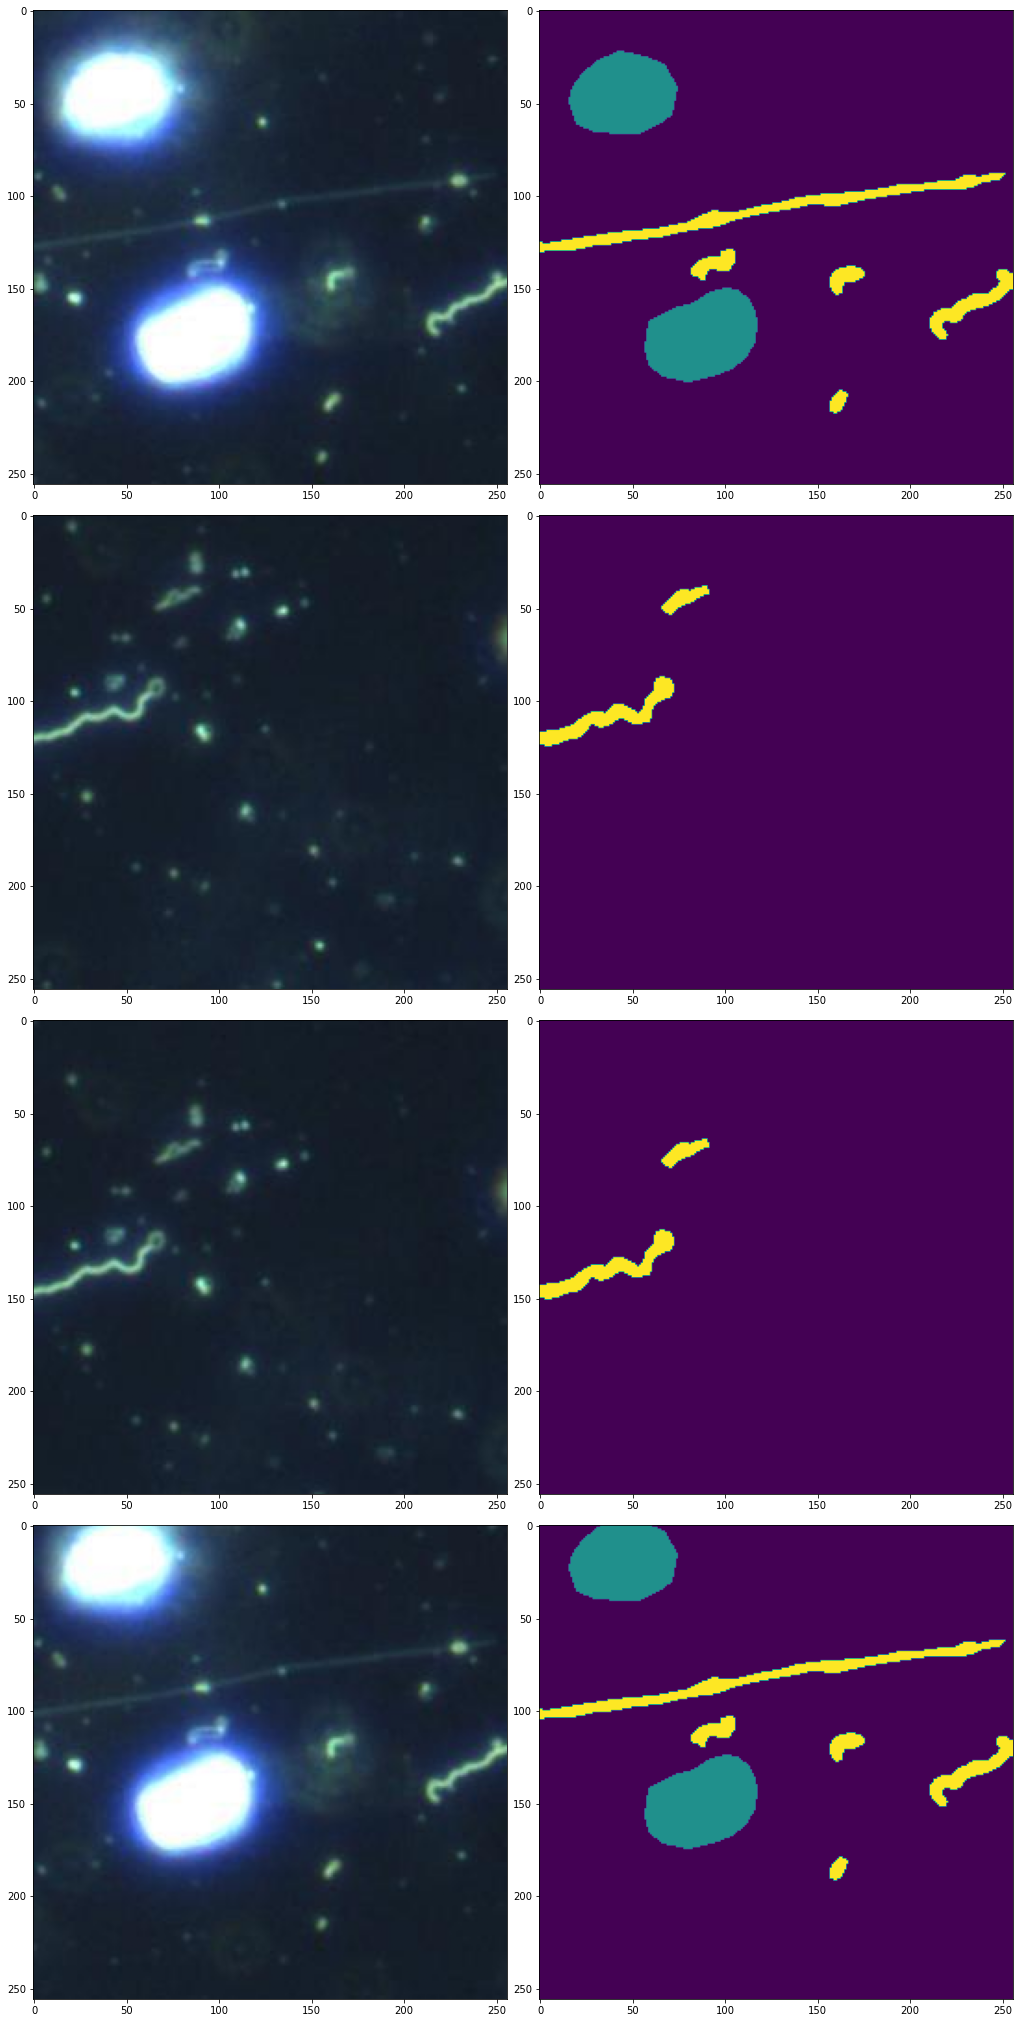

In [7]:
%matplotlib inline
n_examples = 4
examples = [(images[i], masks[i]) for i in range(n_examples)]

fig, axs = plt.subplots(n_examples, 2, figsize=(14, n_examples*7), constrained_layout=True)
for ax, (image, mask) in zip(axs, examples):
    ax[0].imshow(image)
    ax[1].imshow(mask)

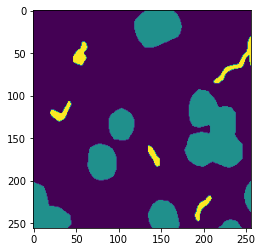

In [8]:
plt.imshow(masks[7])

In [9]:
masksNew = []
imgsNew = []
for i in range(len(masks)):
    if masks[i,:,:,0].max() > 0:
        masksNew.append(masks[i,:,:,:])
        imgsNew.append(images[i,:,:,:])
masks = np.array(masksNew)
images = np.array(imgsNew)
masks.shape, images.shape

((2100, 256, 256, 1), (2100, 256, 256, 3))

In [10]:
images = images[:1000]
masks = masks[:1000]
images.shape, masks.shape

((1000, 256, 256, 3), (1000, 256, 256, 1))

In [11]:
batch_size = 32
test_set_size = 200
validation_set_size = 200

dataset = tf.data.Dataset.from_tensor_slices((images, masks))
dataset = dataset.shuffle(20)

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)

validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)

train_dataset = train_dataset.batch(1).prefetch(5)
validation_dataset = validation_dataset.batch(1).prefetch(5)
test_dataset = test_dataset.batch(1).prefetch(5)

In [12]:
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation
from keras.layers import Input, Dense

def getSegNet():
    inp = Input(shape=(256, 256, 3))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)

    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)

    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)

    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)

    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)

    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)

    pool_3 = MaxPooling2D(2)(conv_3_2)

    conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
    conv_4_1 = Activation('relu')(conv_4_1)

    conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
    conv_4_2 = Activation('relu')(conv_4_2)

    pool_4 = MaxPooling2D(2)(conv_4_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)

    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)

    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)

    conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
    conv_up_3_2 = Activation('relu')(conv_up_3_2)

    up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
    conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(up_4)
    conv_up_4_1 = Activation('relu')(conv_up_4_1)

    conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
    result = Activation('sigmoid')(conv_up_4_2)

    return Model(inputs=inp, outputs=result)

In [18]:
segnet = getSegNet()

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7) # gave an error with keras.optimizers so we used tf.keras.optimizers
segnet.compile(loss='binary_crossentropy', 
              optimizer=optimizer)

In [19]:
segnet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_48 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 conv2d_49 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 activation_49 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                           

In [ ]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1)

epochs = 200
history = segnet.fit(train_dataset, 
                    validation_data=validation_dataset, 
                    epochs=epochs, 
                    callbacks=[early_stopping, lr_reduce])

Epoch 1/200
600/600 [==============================] - 1186s 2s/step - loss: 0.5078 - val_loss: 0.3081 - lr: 0.0010
Epoch 2/200
600/600 [==============================] - 813s 1s/step - loss: 0.2927 - val_loss: 0.2544 - lr: 0.0010
Epoch 3/200
600/600 [==============================] - 1093s 2s/step - loss: 0.2484 - val_loss: 0.2242 - lr: 0.0010
Epoch 4/200
600/600 [==============================] - 900s 2s/step - loss: 0.2326 - val_loss: 0.2025 - lr: 0.0010
Epoch 5/200
441/600 [=====================>........] - ETA: 3:36 - loss: 0.2205

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
n_examples = 3

fig, axs = plt.subplots(n_examples, 3, figsize=(14, n_examples*7), constrained_layout=True)
for ax, ele in zip(axs, test_dataset.take(n_examples)):
    image, y_true = ele
    prediction = segnet.predict(image)[0]
    prediction = tf.where(prediction > 0.35, 255, 0)
    ax[0].set_title('Original image')
    ax[0].imshow(image[0])
    ax[1].set_title('Original mask')
    ax[1].imshow(y_true[0])
    ax[2].set_title('Predicted area')
    ax[2].imshow(prediction)

In [ ]:
meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)

def getDice(y_true, pred):
    up = 2*(y_true*pred).sum()
    down = y_true.sum() + pred.sum()
    if down==0:
        return 1
    else:
        return up / down

DiceVals = []
for image, y_true in test_dataset.take(test_set_size):
    prediction = segnet.predict(image)[0]
    prediction = tf.where(prediction > 0.35, 1, 0).numpy()
    y_true = y_true[0].numpy()
    meanIoU.update_state(y_true, prediction)
    DiceVals.append(getDice(y_true, prediction))

print('Mean IoU:', meanIoU.result().numpy())
print('Mean Dice:', sum(DiceVals)/len(DiceVals))
print('\n')